# 데이터 준비

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from tqdm import tqdm

In [ ]:
import lightgbm as lgb
!pip install catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
total = pd.read_csv('/content/drive/MyDrive/21-2 kubig 분류예측스터디/데이콘 가스공급량/사용 데이터/train_data_all (2).csv')

In [ ]:
total

,Unnamed: 0,연월일,시간,구분,공급량,year,month,day,weekday,공급량_평균,공급량_요일_평균,전년도_공급량,sin_time,cos_time,가스기름상대가격,가스전기상대가격,전산업생산지수,가스수요산업지수,holiday,satsun,is_holiday,year_month,월평균기온,계절,겨울_더미,특정시간_더미,평일,G_공급사
0,0,2013-01-01,1,0,2497.129,2013,1,1,1,1913.798167,2091.462444,NaN,2.588190e-01,0.965926,0.66,108.59,94.3,122.03,1,0,1,2013-01,-3.452554,1,1,0,1,0
1,1,2013-01-01,2,0,2363.265,2013,1,1,1,1801.091833,1845.728111,1765.008,5.000000e-01,0.866025,0.66,108.59,94.3,122.03,1,0,1,2013-01,-3.452554,1,1,0,1,0
2,2,2013-01-01,3,0,2258.505,2013,1,1,1,1696.859000,1729.965741,1679.186,7.071068e-01,0.707107,0.66,108.59,94.3,122.03,1,0,1,2013-01,-3.452554,1,1,0,1,0
3,3,2013-01-01,4,0,2243.969,2013,1,1,1,1689.182667,1783.386852,1610.885,8.660254e-01,0.500000,0.66,108.59,94.3,122.03,1,0,1,2013-01,-3.452554,1,1,0,1,0
4,4,2013-01-01,5,0,2344.105,2013,1,1,1,1796.721167,1975.943778,1604.123,9.659258e-01,0.258819,0.66,108.59,94.3,122.03,1,0,1,2013-01,-3.452554,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368083,368083,2018-12-31,20,6,681.033,2018,12,31,0,575.836167,577.313222,517.264,-8.660254e-01,0.500000,0.74,92.69,116.7,95.56,0,0,0,2018-12,-0.579704,1,1,1,1,0
368084,368084,2018-12-31,21,6,669.961,2018,12,31,0,567.201500,583.881037,530.896,-7.071068e-01,0.707107,0.74,92.69,116.7,95.56,0,0,0,2018-12,-0.579704,1,1,1,1,0
368085,368085,2018-12-31,22,6,657.941,2018,12,31,0,549.175333,567.648000,506.287,-5.000000e-01,0.866025,0.74,92.69,116.7,95.56,0,0,0,2018-12,-0.579704,1,1,0,1,0
368086,368086,2018-12-31,23,6,610.953,2018,12,31,0,512.990500,522.023185,470.638,-2.588190e-01,0.965926,0.74,92.69,116.7,95.56,0,0,0,2018-12,-0.579704,1,1,0,1,0


In [ ]:
total.columns

Index(['Unnamed: 0', '연월일', '시간', '구분', '공급량', 'year', 'month', 'day',
       'weekday', '공급량_평균', '공급량_요일_평균', '전년도_공급량', 'sin_time', 'cos_time',
       '가스기름상대가격', '가스전기상대가격', '전산업생산지수', '가스수요산업지수', 'holiday', 'satsun',
       'is_holiday', 'year_month', '월평균기온', '계절', '겨울_더미', '특정시간_더미', '평일',
       'G_공급사'],
      dtype='object')

## Trian / Validation 구분
- 주의할 점 ! 전년도 자료(ex.전년도 공급량 등 shift해 오는 변수) 사용 시 2013은 제외

In [6]:
train_years = [2013, 2014,2015,2016,2017] 
val_years = [2018]

In [7]:
train = total[total['year'].isin(train_years)]
val = total[total['year'].isin(val_years)]

In [ ]:
train

## (1) LGBM MODELING

- BASE MODELING

In [8]:
lgbm_features =  [ '시간', '구분', 'year', 'month', 'day',
       'weekday',  '공급량_평균', '공급량_요일_평균', 'sin_time', 'cos_time',
       '가스기름상대가격', '가스전기상대가격', '전산업생산지수', '가스수요산업지수', 'holiday', 'satsun',
       'is_holiday', '월평균기온', '계절', '겨울_더미', '특정시간_더미', '평일',
       'G_공급사'] #2013_data썼으니까 전년도 공급량 사용 노 

train_lgbm = train[lgbm_features]
train_y = train['공급량']

val_lgbm = val[lgbm_features]
val_y = val['공급량']

In [9]:
params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

In [ ]:
ds_train = lgb.Dataset(train_lgbm, train_y)
ds_val = lgb.Dataset(val_lgbm, val_y)


lgbm_model = lgb.train(params, ds_train, 20000, ds_val, early_stopping_rounds=100)

- lgb.train 옵션 확인
    - n_estimators : 부스팅 이터레이션 수로 모델 성능과 학습시간, 램 사용량에 영향을 준다. 큰 값을 넣은 후에 early stopping과 함께 사용하는 것이 좋다.  
    - early_stopping_rounds : 학습 조기종료를 위한 early stopping interval 값 (보통 50~100 사이) 
    - early_stopping_rounds를 사용하기 위해서는 조기중단을 위한 평가지표인 eval_metric과 성능평가를 수행할 데이터셋인 eval_set을 함께 지정해줘야 한다.

In [12]:
valid =val_y.values

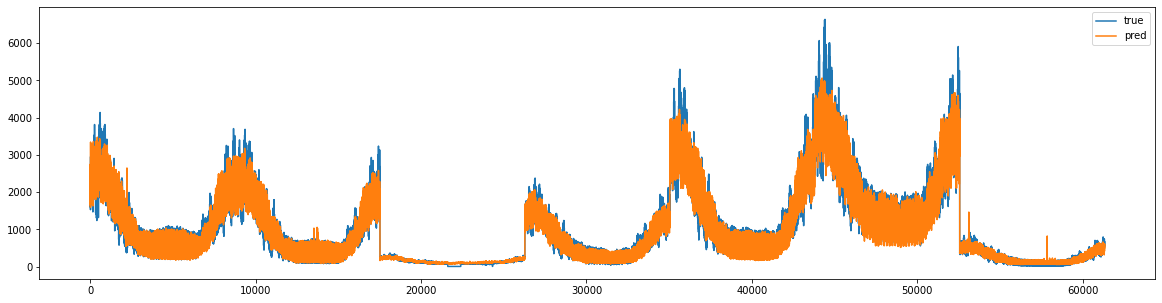

In [13]:
y_val_lgbm_pred = lgbm_model.predict(val_lgbm)

plt.figure(figsize=(20,5))
plt.plot(valid, label='true')
plt.plot(y_val_lgbm_pred, label='pred')
plt.legend()
plt.show()

In [14]:
y_train_lgbm_pred = lgbm_model.predict(train_lgbm)
y_val_lgbm_pred = lgbm_model.predict(val_lgbm)

In [15]:
#CV SCORE
print('Train nmae:', np.mean((np.abs(train_y - y_train_lgbm_pred))/train_y))
print('Validation nmae:', np.mean((np.abs(val_y - y_val_lgbm_pred))/val_y))

Train nmae: 0.5239224463294758
Validation nmae: 0.5617704298353239


# 파라미터 튜닝

In [ ]:
!pip install optuna
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import log_loss
from sklearn.metrics import mean_absolute_error

In [ ]:
# 1. max_depth 먼저 튜닝
def objective(trial: Trial) -> float:
    param = {
        'metric': 'mae', 
        'random_state': 42,
        'max_depth': trial.suggest_categorical('max_depth', [-1, 3,4,5,6,7,8,9,10,11,12]),
    }
    model = lgb.LGBMRegressor(**param)  
    
    model.fit(train_lgbm, train_y,eval_set=[(val_lgbm, val_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(val_lgbm)
    
    mae = mean_absolute_error(val_y, preds)
    
    return mae

- 주요 파라미터
    - `max_depth` : 파라미터 설정 시 우선적으로 지정. 각 트리의 최대 깊이. 최대 리프 수(Maximum Leaves), 모형 성능, 학습 시간에 영향을 준다. 클수록 학습 데이터에 피팅이 잘 되지만 오버피팅될 가능성도 높아진다. 보통 3~12의 값을 사용한다. 무한 깊이(가능한 최대로 트리 스플릿)로 학습시키려면 xgboost에서는 0, lightgbm에서는 -1로 설정하면 된다. lightgbm 같이 leaf-wise로 학습하는 경우에는 max_depth를 -1로 설정하는 것이 효과적이라고 알려져 있다.

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params) #Best trial: {'max_depth': 4} w/h 119.90027920285708.

[I 2021-11-28 05:26:53,270] A new study created in memory with name: no-name-c24fabe7-335d-44bf-ba16-83be4ed90fcb
[I 2021-11-28 05:26:57,542] Trial 0 finished with value: 125.53654530208138 and parameters: {'max_depth': 11}. Best is trial 0 with value: 125.53654530208138.
[I 2021-11-28 05:27:01,151] Trial 1 finished with value: 119.90027920285708 and parameters: {'max_depth': 4}. Best is trial 1 with value: 119.90027920285708.
[I 2021-11-28 05:27:05,417] Trial 2 finished with value: 122.73934154595038 and parameters: {'max_depth': 12}. Best is trial 1 with value: 119.90027920285708.
[I 2021-11-28 05:27:09,651] Trial 3 finished with value: 122.58536389139627 and parameters: {'max_depth': 8}. Best is trial 1 with value: 119.90027920285708.
[I 2021-11-28 05:27:13,915] Trial 4 finished with value: 122.58536389139627 and parameters: {'max_depth': 8}. Best is trial 1 with value: 119.90027920285708.
[I 2021-11-28 05:27:18,240] Trial 5 finished with value: 122.88412201578195 and parameters: {'

Number of finished trials: 50
Best trial: {'max_depth': 4}


- optuna 튜닝. 이때 loss를 최소화하는 방향으로 최적화 -> direction : minimize

In [17]:
def objective2(trial: Trial) -> float:
    param = {
        'metric': 'mae', 
        'random_state': 42,
        'max_depth': 4,
        'n_estimators': 10000,
        'boosting_type' : ['gbdt'],
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.05, 0.1]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
    }
    model = lgb.LGBMRegressor(**param)  
    
    model.fit(train_lgbm, train_y,eval_set=[(val_lgbm, val_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(val_lgbm)
    
    mae = mean_absolute_error(val_y, preds)
    
    return mae

- 주요 파라미터
- 이제 metric : mae, random_State 2로 고정, max_depth 4로 고정, n_estimator 10000으로 고정, boosting type은 그레디언트 부스팅 고정
    - `num_leaves` : `그라디언트 부스팅에서 두번째로 민감한 하이퍼파라미터로 Maximum Depth와 함께 튜닝해주는 것이 좋다. lightgbm에서 디폴트 값이 31로 작은 것도 lightgbm의 디폴트가 무한 깊이로 트리를 만드는 것이기 때문에 너무 거대한 트리가 만들어져 train 데이터에 과적합 되는 것을 막기 위한 설정으로 보인다. Maximum Depth 별로 여러 개의 Maximum Leaves의 조합을 만들어 cross validation 성능이 가장 좋은 조합을 찾아보는 것이 좋다.
    - 그 후 `min_child_samples` 튜닝 -> 그 외 파라미터도 다 후보군으로 넣어줌
    - `learning rate`의 경우 0.01~0.1 정도로 맞추고 다른 파라미터를 수정해줌. 부스팅 각 이터레이션 마다 곱해지는 가중치(loss function의 step size)로 모형 성능과 학습시간에 영향을 준다. 보통 작을수록 모형 성능 향상에 도움이 되지만 학습 시간은 길어지는 trade-off가 있다.

In [18]:
study = optuna.create_study(direction='minimize')
study.optimize(objective2, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params) #{'num_leaves': 319, 'min_child_samples': 173, 'learning_rate': 0.05, 'reg_alpha': 0.06560362905803538, 'reg_lambda': 0.03449317677636304, 'colsample_bytree': 0.9, 'subsample': 0.7}

[I 2021-11-28 10:02:45,928] A new study created in memory with name: no-name-46dda779-aac4-426b-a386-24171fa1cd94
[I 2021-11-28 10:02:52,917] Trial 0 finished with value: 120.06082933691322 and parameters: {'num_leaves': 105, 'min_child_samples': 263, 'learning_rate': 0.05, 'reg_alpha': 0.16715658324840313, 'reg_lambda': 0.0011830438487021022, 'colsample_bytree': 0.9, 'subsample': 0.6}. Best is trial 0 with value: 120.06082933691322.
[I 2021-11-28 10:03:14,027] Trial 1 finished with value: 124.13879241858636 and parameters: {'num_leaves': 928, 'min_child_samples': 289, 'learning_rate': 0.01, 'reg_alpha': 0.0023048400837451816, 'reg_lambda': 0.3210702861982246, 'colsample_bytree': 0.6, 'subsample': 1.0}. Best is trial 0 with value: 120.06082933691322.
[I 2021-11-28 10:03:46,116] Trial 2 finished with value: 120.50214320342394 and parameters: {'num_leaves': 991, 'min_child_samples': 51, 'learning_rate': 0.01, 'reg_alpha': 0.1310780484387982, 'reg_lambda': 6.454623621076978, 'colsample_by

Number of finished trials: 50
Best trial: {'num_leaves': 319, 'min_child_samples': 173, 'learning_rate': 0.05, 'reg_alpha': 0.06560362905803538, 'reg_lambda': 0.03449317677636304, 'colsample_bytree': 0.9, 'subsample': 0.7}


참고 : https://sites.google.com/view/lauraepp/parameters


In [ ]:
params=study.best_params   

In [19]:
params=study.best_params   
params['metric'] = 'mae'
params['random_state'] = 42
params['max_depth'] = 4
params['n_estimators'] = 10000
params['boosting_type'] = ['gbdt']

In [20]:
params

{'boosting_type': ['gbdt'],
 'colsample_bytree': 0.9,
 'learning_rate': 0.05,
 'max_depth': 4,
 'metric': 'mae',
 'min_child_samples': 173,
 'n_estimators': 10000,
 'num_leaves': 319,
 'random_state': 42,
 'reg_alpha': 0.06560362905803538,
 'reg_lambda': 0.03449317677636304,
 'subsample': 0.7}

In [21]:
# 파라미터 !!! 
params = {
    'objective': 'regression',
'boosting_type': ['gbdt'],
 'colsample_bytree': 0.9,
 'learning_rate': 0.05,
 'max_depth': 4,
 'metric': 'mae',
 'min_child_samples': 173,
 'n_estimators': 10000,
 'num_leaves': 319,
 'random_state': 42,
 'reg_alpha': 0.06560362905803538,
 'reg_lambda': 0.03449317677636304,
 'subsample': 0.7}

In [ ]:
ds_train = lgb.Dataset(train_lgbm, train_y)
ds_val = lgb.Dataset(val_lgbm, val_y)


lgbm_model = lgb.train(params, ds_train, 10000, ds_val, early_stopping_rounds=100)

In [23]:
valid =val_y.values

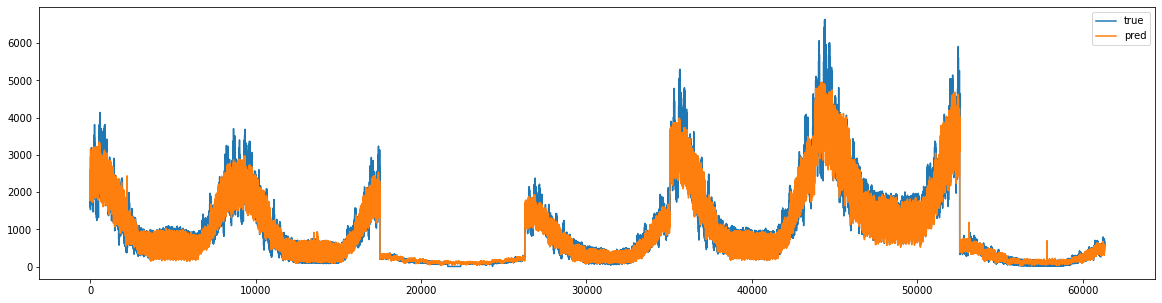

In [ ]:
y_val_lgbm_pred = lgbm_model.predict(val_lgbm)

plt.figure(figsize=(20,5))
plt.plot(valid, label='true')
plt.plot(y_val_lgbm_pred, label='pred')
plt.legend()
plt.show()

In [24]:
y_train_lgbm_pred = lgbm_model.predict(train_lgbm)
y_val_lgbm_pred = lgbm_model.predict(val_lgbm)

In [25]:
#CV SCORE
print('Train nmae:', np.mean((np.abs(train_y - y_train_lgbm_pred))/train_y))
print('Validation nmae:', np.mean((np.abs(val_y - y_val_lgbm_pred))/val_y))

Train nmae: 0.507615012787435
Validation nmae: 0.552352746135434


In [26]:
lgbm_prediction_df = pd.DataFrame(val['연월일'], columns=['연월일'])
lgbm_prediction_df['공급량'] = val['공급량']
lgbm_prediction_df['예측'] = y_val_lgbm_pred
lgbm_prediction_df

,연월일,공급량,예측
306768,2018-01-01,1765.008,2065.050596
306769,2018-01-01,1679.186,1935.783964
306770,2018-01-01,1610.885,1786.693386
306771,2018-01-01,1604.123,1812.303432
306772,2018-01-01,1711.506,2000.772947
...,...,...,...
368083,2018-12-31,681.033,566.438070
368084,2018-12-31,669.961,563.123277
368085,2018-12-31,657.941,539.106245
368086,2018-12-31,610.953,503.049010


## (2) XGBoost MODELING

In [ ]:
xgb_features =  [ '시간', '구분', 'year', 'month', 'day',
       'weekday',  '공급량_평균', '공급량_요일_평균', 'sin_time', 'cos_time',
       '가스기름상대가격', '가스전기상대가격', '전산업생산지수', '가스수요산업지수', 'holiday', 'satsun',
       'is_holiday', '월평균기온', '계절', '겨울_더미', '특정시간_더미', '평일',
       'G_공급사']
              
xgb_train = train_x[xgb_features]
xgb_val = val_x[xgb_features]

In [ ]:
params = {
    'learning_rate': 0.02,
    'objective': 'reg:squarederror',
    'eval_metric':'mae', 
    'seed':42
}

In [ ]:
import xgboost as xgb

d_train = xgb.DMatrix(data=xgb_train, label = train_y)
d_val = xgb.DMatrix(data=xgb_val, label = val_y)
wlist = [(d_train, 'train'), (d_val,'eval')]

xgb_model = xgb.train(params, d_train, 1000, evals=wlist, verbose_eval=100, early_stopping_rounds=100)

[0]	train-mae:915.679	eval-mae:994.403
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 100 rounds.
[100]	train-mae:138.705	eval-mae:178.739
[200]	train-mae:78.96	eval-mae:124.195
[300]	train-mae:70.6544	eval-mae:122.716
Stopping. Best iteration:
[274]	train-mae:72.6429	eval-mae:122.413



In [ ]:
xgb_train_pred = (xgb_model.predict(d_train))
xgb_val_pred = (xgb_model.predict(d_val))

In [ ]:
#CV SCORE
print('Train nmae:', np.mean((np.abs(train_y - xgb_train_pred))/train_y))
print('Validation nmae:', np.mean((np.abs(val_y - xgb_val_pred))/val_y))

Train nmae: 0.443367659380328
Validation nmae: 0.5227250516821166


In [ ]:
xgb_prediction_df = pd.DataFrame(val['연월일'], columns=['연월일'])
xgb_prediction_df['공급량'] = val['공급량']
xgb_prediction_df['예측'] = xgb_val_pred
xgb_prediction_df

,연월일,공급량,예측
306768,2018-01-01,1765.008,1843.285645
306769,2018-01-01,1679.186,1732.636475
306770,2018-01-01,1610.885,1669.141846
306771,2018-01-01,1604.123,1719.699097
306772,2018-01-01,1711.506,1805.662842
...,...,...,...
368083,2018-12-31,681.033,579.302490
368084,2018-12-31,669.961,573.272949
368085,2018-12-31,657.941,561.631775
368086,2018-12-31,610.953,509.979736


#  결과 제출

'연월일', '시간', '구분', '공급량', 'year', 'month', 'day',
       'weekday', '공급량_평균', '공급량_요일_평균', '전년도_공급량', 'sin_time', 'cos_time',
       '가스기름상대가격', '가스전기상대가격', '전산업생산지수', '가스수요산업지수', '계절', '겨울_더미', '특정시간_더미',
       '평일', 'G_공급사'

In [ ]:
PATH = '/content/drive/MyDrive/21-2 kubig 분류예측스터디/데이콘 가스공급량/사용 데이터/'

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/21-2 kubig 분류예측스터디/데이콘 가스공급량/사용 데이터/test_data_all (1).csv')
submission = pd.read_csv(PATH + 'sample_submission.csv')

In [ ]:
test

,Unnamed: 0,일자|시간|구분,일자,시간,구분,year,month,day,weekday,공급량_평균,sin_time,cos_time,전년도_공급량,계절,겨울_더미,특정시간_더미,평일,G_공급사,holiday,satsun,is_holiday,year_month,월평균기온,공급량_요일_평균,가스기름상대가격,가스전기상대가격,전산업생산지수,가스수요산업지수
0,0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1,1913.798167,2.588190e-01,0.965926,1765.008,1,1,0,1,0,1,0,1,2019-01,-1.0,2091.462444,0.74,92.69,116.7,94.88
1,1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1,1801.091833,5.000000e-01,0.866025,1679.186,1,1,0,1,0,1,0,1,2019-01,-1.0,1845.728111,0.74,92.69,116.7,94.88
2,2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1,1696.859000,7.071068e-01,0.707107,1610.885,1,1,0,1,0,1,0,1,2019-01,-1.0,1729.965741,0.74,92.69,116.7,94.88
3,3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1,1689.182667,8.660254e-01,0.500000,1604.123,1,1,0,1,0,1,0,1,2019-01,-1.0,1783.386852,0.74,92.69,116.7,94.88
4,4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1,1796.721167,9.659258e-01,0.258819,1711.506,1,1,0,1,0,1,0,1,2019-01,-1.0,1975.943778,0.74,92.69,116.7,94.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,15115,2019-03-31 20 H,2019-03-31,20,6,2019,3,31,6,316.634333,-8.660254e-01,0.500000,244.162,2,0,1,0,0,0,1,1,2019-03,6.0,423.036667,0.74,92.69,116.7,104.06
15116,15116,2019-03-31 21 H,2019-03-31,21,6,2019,3,31,6,327.582500,-7.071068e-01,0.707107,248.059,2,0,1,0,0,0,1,1,2019-03,6.0,428.752407,0.74,92.69,116.7,104.06
15117,15117,2019-03-31 22 H,2019-03-31,22,6,2019,3,31,6,311.249500,-5.000000e-01,0.866025,231.181,2,0,0,0,0,0,1,1,2019-03,6.0,394.682074,0.74,92.69,116.7,104.06
15118,15118,2019-03-31 23 H,2019-03-31,23,6,2019,3,31,6,277.961667,-2.588190e-01,0.965926,199.022,2,0,0,0,0,0,1,1,2019-03,6.0,352.585778,0.74,92.69,116.7,104.06


In [ ]:
test_x = test[[ '시간', '구분', 'year', 'month', 'day',
       'weekday',  '공급량_평균', '공급량_요일_평균', 'sin_time', 'cos_time',
       '가스기름상대가격', '가스전기상대가격', '전산업생산지수', '가스수요산업지수', 'holiday', 'satsun',
       'is_holiday', '월평균기온', '계절', '겨울_더미', '특정시간_더미', '평일',
       'G_공급사']] 

In [ ]:
test_x

,시간,구분,year,month,day,weekday,공급량_평균,공급량_요일_평균,sin_time,cos_time,가스기름상대가격,가스전기상대가격,전산업생산지수,가스수요산업지수,holiday,satsun,is_holiday,월평균기온,계절,겨울_더미,특정시간_더미,평일,G_공급사
0,1,0,2019,1,1,1,1913.798167,2091.462444,2.588190e-01,0.965926,0.74,92.69,116.7,94.88,1,0,1,-1.0,1,1,0,1,0
1,2,0,2019,1,1,1,1801.091833,1845.728111,5.000000e-01,0.866025,0.74,92.69,116.7,94.88,1,0,1,-1.0,1,1,0,1,0
2,3,0,2019,1,1,1,1696.859000,1729.965741,7.071068e-01,0.707107,0.74,92.69,116.7,94.88,1,0,1,-1.0,1,1,0,1,0
3,4,0,2019,1,1,1,1689.182667,1783.386852,8.660254e-01,0.500000,0.74,92.69,116.7,94.88,1,0,1,-1.0,1,1,0,1,0
4,5,0,2019,1,1,1,1796.721167,1975.943778,9.659258e-01,0.258819,0.74,92.69,116.7,94.88,1,0,1,-1.0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,20,6,2019,3,31,6,316.634333,423.036667,-8.660254e-01,0.500000,0.74,92.69,116.7,104.06,0,1,1,6.0,2,0,1,0,0
15116,21,6,2019,3,31,6,327.582500,428.752407,-7.071068e-01,0.707107,0.74,92.69,116.7,104.06,0,1,1,6.0,2,0,1,0,0
15117,22,6,2019,3,31,6,311.249500,394.682074,-5.000000e-01,0.866025,0.74,92.69,116.7,104.06,0,1,1,6.0,2,0,0,0,0
15118,23,6,2019,3,31,6,277.961667,352.585778,-2.588190e-01,0.965926,0.74,92.69,116.7,104.06,0,1,1,6.0,2,0,0,0,0


##(1) LGBM 모델링 결과 제출

In [ ]:
ensem_lgbm_preds = (lgbm_model.predict(test_x))



In [ ]:
xgb_test_x = xgb.DMatrix(test_x)
ensem_xgb_preds = (xgb_model.predict(xgb_test_x))

In [ ]:
submission['공급량'] = ensem_lgbm_preds *0.6 + ensem_xgb_preds * 0.4

In [ ]:
submission

,일자|시간|구분,공급량
0,2019-01-01 01 A,1776.291963
1,2019-01-01 02 A,1659.427669
2,2019-01-01 03 A,1566.473369
3,2019-01-01 04 A,1565.333467
4,2019-01-01 05 A,1689.683545
...,...,...
15115,2019-03-31 20 H,346.725562
15116,2019-03-31 21 H,354.394403
15117,2019-03-31 22 H,336.451940
15118,2019-03-31 23 H,303.941975


In [ ]:
PATH = '/content/drive/MyDrive/21-2 kubig 분류예측스터디/데이콘 가스공급량/제출용/'

In [ ]:
submission.to_csv(PATH + 'lgbm_파라미터튜닝_64.csv', index=False)

점수 : 0.1152168514